# Фаза 2 • Неделя 8 • Четверг
## Нейронные сети
### 🔥 PyTorch: fine tuning

In [1]:
!pip -qq install torchutils

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


### Подготовка к работе

1. Загрузи этот ноутбук на Google Colab
2. Подгрузи архив [датасета](https://www.kaggle.com/datasets/ikobzev/architectural-heritage-elements-image64-dataset) в свое пространство и разархивируй его с помощью `unzip`.

In [7]:
from google.colab import drive
drive.mount('archive.zip')

Mounted at archive.zip


In [8]:
!unzip /archive.zip -d /content

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/train/dome(outer)/1294.jpg  
  inflating: /content/train/dome(outer)/1295.jpg  
  inflating: /content/train/dome(outer)/1296.jpg  
  inflating: /content/train/dome(outer)/1297.jpg  
  inflating: /content/train/dome(outer)/1298.jpg  
  inflating: /content/train/dome(outer)/1299.jpg  
  inflating: /content/train/dome(outer)/1300.jpg  
  inflating: /content/train/dome(outer)/1301.jpg  
  inflating: /content/train/dome(outer)/1302.jpg  
  inflating: /content/train/dome(outer)/1303.jpg  
  inflating: /content/train/dome(outer)/1304.jpg  
  inflating: /content/train/dome(outer)/1305.jpg  
  inflating: /content/train/dome(outer)/1306.jpg  
  inflating: /content/train/dome(outer)/1307.jpg  
  inflating: /content/train/dome(outer)/1308.jpg  
  inflating: /content/train/dome(outer)/1309.jpg  
  inflating: /content/train/dome(outer)/1310.jpg  
  inflating: /content/train/dome(outer)/1311.jpg  
  inflating: /

In [9]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

trnsfrms = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ]
)

trnsfrm_train = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [10]:
train_dataset = torchvision.datasets.ImageFolder(
    '/content/train',
    transform=trnsfrm_train
)
valid_dataset = torchvision.datasets.ImageFolder(
    '/content/test',
    transform=trnsfrms
)

In [11]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 10130
    Root location: /content/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [12]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 1404
    Root location: /content/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

1. Убедись, что структура папок соответствует задаче классификации (либо приведите ее к формату, указанному ниже):

        `train`
        
            - class_1
            - class_2
            - ...
            - class_n
            
        `valid`

            - class_1
            - class_2
            - ...
            - class_n

In [13]:
train_dataset.class_to_idx

{'altar': 0,
 'apse': 1,
 'bell_tower': 2,
 'column': 3,
 'dome(inner)': 4,
 'dome(outer)': 5,
 'flying_buttress': 6,
 'gargoyle': 7,
 'stained_glass': 8,
 'vault': 9}

In [14]:
train_dataset.class_to_idx == valid_dataset.class_to_idx

True

2. Создай `DataLoader` в для обучающей и валидационных выборок. Примените аугментации к изображениям.

In [15]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, shuffle=True, drop_last=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=BATCH_SIZE)

3. Создай экземпляр предобученной модели: [torchvision models](https://pytorch.org/vision/stable/models.html). Можно взять любую модель для baseline, а дальше попробовать что-то более сложное.

In [16]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)

fake_batch = torch.randn(4, 3, 224, 224, device=DEVICE)
tu.get_model_summary(model, fake_batch)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.2MB/s]


Layer                                       Kernel             Output          Params           FLOPs
0_conv1                                   [3, 64, 7, 7]   [4, 64, 112, 112]       9,408   472,055,808
1_bn1                                              [64]   [4, 64, 112, 112]         128    12,845,056
2_relu                                                -   [4, 64, 112, 112]           0             0
3_maxpool                                             -     [4, 64, 56, 56]           0             0
4_layer1.0.Conv2d_conv1                  [64, 64, 3, 3]     [4, 64, 56, 56]      36,864   462,422,016
5_layer1.0.BatchNorm2d_bn1                         [64]     [4, 64, 56, 56]         128     3,211,264
6_layer1.0.ReLU_relu                                  -     [4, 64, 56, 56]           0             0
7_layer1.0.Conv2d_conv2                  [64, 64, 3, 3]     [4, 64, 56, 56]      36,864   462,422,016
8_layer1.0.BatchNorm2d_bn2                         [64]     [4, 64, 56, 56]       

In [17]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

5. Замени выходной слой форматом, который подходит под задачу: бинарная или многоклассовая классификация.

In [25]:
class MyResNet(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
    self.model.fc = nn.Linear(in_features=512, out_features=10)

    for param in self.model.parameters():
      param.requires_grad = False
    self.model.fc.weight.requires_grad = True
    self.model.fc.bias.requires_grad = True

  def forward(self, x):
    return self.model(x)

model = MyResNet()
model.to(DEVICE);

6. Обучи модель (только последний слой!) и зафиксируй метрику на валидационной части выборки.

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.CrossEntropyLoss()

In [27]:
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc =[]
for epoch in range(8):
    model.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images).squeeze(-1)
        loss = criterion(preds, labels)
        loss_batch.append(loss.item())
        accuracy = (preds.argmax(dim=1) == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            preds = model(images).squeeze(-1)

        loss = criterion(preds, labels)
        loss_batch.append(loss.item())

        accuracy = (preds.argmax(dim=1) == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))

    print(f'Epoch: {epoch}  loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
    print(f'\t  metrics_train: {train_epoch_acc[-1]:.3f}, metrics_valid: {valid_epoch_acc[-1]:.3f}')

Epoch: 0  loss_train: 1.038, loss_valid: 0.591
	  metrics_train: 0.679, metrics_valid: 0.808
Epoch: 1  loss_train: 0.684, loss_valid: 0.575
	  metrics_train: 0.774, metrics_valid: 0.804
Epoch: 2  loss_train: 0.648, loss_valid: 0.492
	  metrics_train: 0.788, metrics_valid: 0.834
Epoch: 3  loss_train: 0.609, loss_valid: 0.457
	  metrics_train: 0.799, metrics_valid: 0.855
Epoch: 4  loss_train: 0.611, loss_valid: 0.433
	  metrics_train: 0.793, metrics_valid: 0.854
Epoch: 5  loss_train: 0.582, loss_valid: 0.395
	  metrics_train: 0.804, metrics_valid: 0.865
Epoch: 6  loss_train: 0.593, loss_valid: 0.409
	  metrics_train: 0.801, metrics_valid: 0.859
Epoch: 7  loss_train: 0.579, loss_valid: 0.407
	  metrics_train: 0.807, metrics_valid: 0.863


7. Распечатай изображение из тестовой выборки и подпиши класс картинки, предсказанный моделью.

In [28]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'altar',
 1: 'apse',
 2: 'bell_tower',
 3: 'column',
 4: 'dome(inner)',
 5: 'dome(outer)',
 6: 'flying_buttress',
 7: 'gargoyle',
 8: 'stained_glass',
 9: 'vault'}

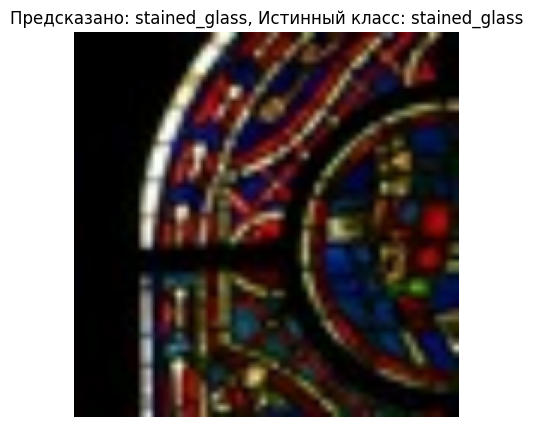

In [29]:
random_idx = np.random.randint(0, len(valid_loader.dataset) - 1)

image, label = valid_loader.dataset[random_idx]

image = image.to(DEVICE)

#model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0))
    predicted_class = output.argmax(dim=1).item()

image = image.cpu()
image = image * std[:, None, None] + mean[:, None, None]
image = image.numpy().transpose((1, 2, 0))
image = image.clip(0, 1)

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(f"Предсказано: {idx2class[predicted_class]}, Истинный класс: {idx2class[label]}")
plt.axis('off')
plt.show()


8. "Разморозь" несоклько слоев базовой модели и вновь обучи ее. Зафиксируй метрику качества для модели. О том, как сделать unfreeze нескольких слоев сразу, а не только последнего, можно почитать тут: [discuss.pytorch.org](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/3)

In [30]:
class MyResNet(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
    self.model.fc = nn.Linear(in_features=512, out_features=10)

    for param in self.model.parameters():
      param.requires_grad = False

    for param in self.model.layer4.parameters():
      param.requires_grad = True

  def forward(self, x):
    return self.model(x)

model = MyResNet()
model.to(DEVICE);

In [31]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.002)
criterion = torch.nn.CrossEntropyLoss()

train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc = []

for epoch in range(8):
    model.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images).squeeze(-1)
        loss = criterion(preds, labels)
        loss_batch.append(loss.item())
        accuracy = (preds.argmax(dim=1) == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            preds = model(images).squeeze(-1)

        loss = criterion(preds, labels)
        loss_batch.append(loss.item())

        accuracy = (preds.argmax(dim=1) == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))

    print(f'Epoch: {epoch}  loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
    print(f'\t  metrics_train: {train_epoch_acc[-1]:.3f}, metrics_valid: {valid_epoch_acc[-1]:.3f}')

Epoch: 0  loss_train: 0.646, loss_valid: 0.388
	  metrics_train: 0.785, metrics_valid: 0.881
Epoch: 1  loss_train: 0.493, loss_valid: 0.288
	  metrics_train: 0.835, metrics_valid: 0.903
Epoch: 2  loss_train: 0.450, loss_valid: 0.328
	  metrics_train: 0.846, metrics_valid: 0.895
Epoch: 3  loss_train: 0.416, loss_valid: 0.271
	  metrics_train: 0.863, metrics_valid: 0.909
Epoch: 4  loss_train: 0.387, loss_valid: 0.245
	  metrics_train: 0.869, metrics_valid: 0.917
Epoch: 5  loss_train: 0.358, loss_valid: 0.241
	  metrics_train: 0.877, metrics_valid: 0.923
Epoch: 6  loss_train: 0.345, loss_valid: 0.177
	  metrics_train: 0.882, metrics_valid: 0.937
Epoch: 7  loss_train: 0.338, loss_valid: 0.205
	  metrics_train: 0.887, metrics_valid: 0.935


9. Сравни качество двух моделей: предобученной с замененным выходным слоем и дообученной с несколькими размороженными слоями.

Добучив слой layer4 мы получили 7% повышения точности предсказания

<img src="https://icons.iconarchive.com/icons/icons8/windows-8/256/Programming-Github-icon.png" width=32 /> Сохрани файл для __github__ и распечатай результат команды `!git status` в ячейке ниже.

10. Сохрани модель (пример можно посмотреть [тут](../../learning/aux/model_saving.ipynb) или в [документации](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [36]:
torch.save(model.state_dict(), 'my_resnet18_weights.pth')

11. Реализуй функцию, которая на вход принимает путь к файлу, а в ответ возвращает класс объекта.

In [ ]:
def get_prediction(path: str) -> str:
    pass

12. Сохрани ноутбук на github